### 📦 required packages

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Start timer
import time
start = time.time()

# All required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Dataset folder and save paths
data_dir = "/content/drive/MyDrive/project/AI-Driven Thermal System Design/data_set"
output_best = "/content/drive/MyDrive/project/AI-Driven Thermal System Design/best_configs.csv"
output_all = "/content/drive/MyDrive/project/AI-Driven Thermal System Design/all_configs.csv"
model_path = "/content/drive/MyDrive/project/AI-Driven Thermal System Design/best_model.pkl"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 📥 Load datasets & 🧹 Preprocess

In [2]:
# Load all person datasets
person_files = [f"{data_dir}/itcm_dataset_person{i}_{n}.csv" for i, n in zip(range(1, 7), [346, 385, 345, 448, 385, 374])]
df = pd.concat([pd.read_csv(f) for f in person_files], ignore_index=True)

# Preprocess
df = df.dropna(subset=["at", "rh", "met", "cl", "hr", "st"])
df = df.rename(columns={
    "at": "temp", "rh": "humidity", "met": "metabolic_rate",
    "cl": "clothing_insulation", "hr": "heart_rate", "st": "skin_temp"
})
features = ["temp", "humidity", "metabolic_rate", "clothing_insulation"]
X = df[features]
y_hr = df["heart_rate"]
y_st = df["skin_temp"]

### 🤖 Train models

In [3]:
# Train models
# RandomForest for heart rate
X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X, y_hr, test_size=0.2, random_state=42)
hr_model = RandomForestRegressor()
hr_model.fit(X_train_hr, y_train_hr)

# XGBoost for skin temperature
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X, y_st, test_size=0.2, random_state=42)
st_model = XGBRegressor(n_estimators=50, max_depth=3, verbosity=0)
st_model.fit(X_train_st, y_train_st)

# Evaluation metrics
y_hr_pred = hr_model.predict(X_test_hr)
y_st_pred = st_model.predict(X_test_st)
print("🔍 Heart Rate Model - R²:", round(r2_score(y_test_hr, y_hr_pred), 3),
      "| MSE:", round(mean_squared_error(y_test_hr, y_hr_pred), 3))
print("🔍 Skin Temp Model - R²:", round(r2_score(y_test_st, y_st_pred), 3),
      "| MSE:", round(mean_squared_error(y_test_st, y_st_pred), 3))

🔍 Heart Rate Model - R²: 0.022 | MSE: 75.291
🔍 Skin Temp Model - R²: 0.699 | MSE: 1.207


### 🔍 Optimization

In [4]:
# Optimization function
def optimize(models, param_ranges, n=1000, alpha=1.0, beta=1.0):
    param_grid = {
        key: np.random.uniform(low, high, n)
        for key, (low, high) in param_ranges.items()
    }
    df_candidates = pd.DataFrame(param_grid)
    input_cols = list(param_ranges.keys())
    df_candidates["heart_rate"] = models["hr"].predict(df_candidates[input_cols])
    df_candidates["skin_temp"] = models["st"].predict(df_candidates[input_cols])
    df_candidates["score"] = -alpha * df_candidates["heart_rate"] - beta * df_candidates["skin_temp"]
    best = df_candidates.sort_values("score", ascending=True).head(10)
    return best, df_candidates

# Parameter search space
param_ranges = {
    "temp": (24, 28),
    "humidity": (40, 70),
    "metabolic_rate": (1.0, 2.5),
    "clothing_insulation": (0.3, 1.2),
}

# Run optimization
models = {"hr": hr_model, "st": st_model}
best_configs, all_preds = optimize(models, param_ranges)

### 📊 Visualization

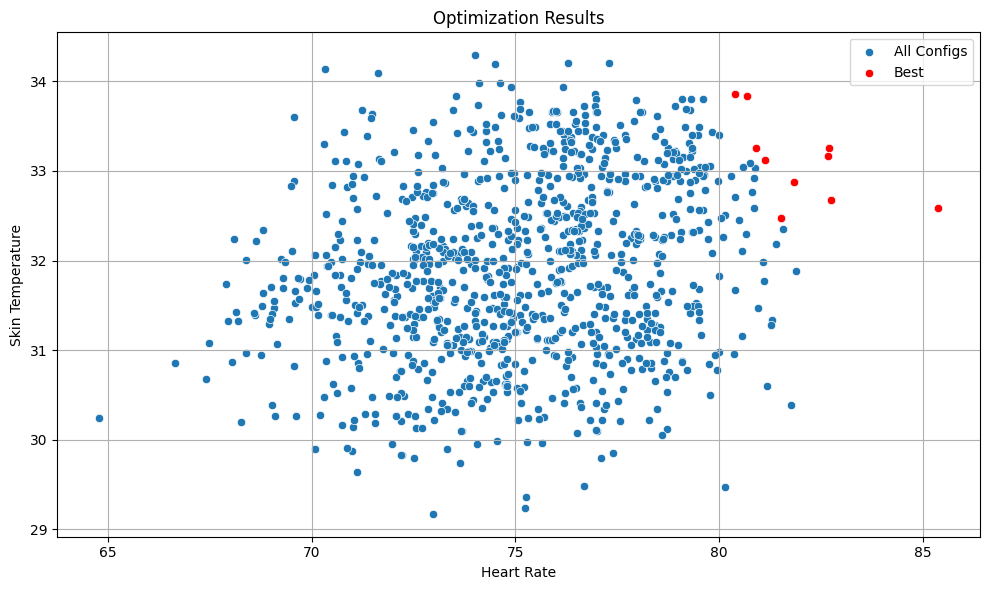

In [5]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_preds, x="heart_rate", y="skin_temp", label="All Configs")
sns.scatterplot(data=best_configs, x="heart_rate", y="skin_temp", color="red", label="Best")
plt.title("Optimization Results")
plt.xlabel("Heart Rate")
plt.ylabel("Skin Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 💾 Save configs

In [6]:
# Save configs
best_configs = best_configs.sort_values("score", ascending=True)
best_configs.to_csv(output_best, index=False)
all_preds.to_csv(output_all, index=False)
print(f"✅ Saved best configs to: {output_best}")
print(f"📦 Saved all configs to: {output_all}")

✅ Saved best configs to: /content/drive/MyDrive/project/AI-Driven Thermal System Design/best_configs.csv
📦 Saved all configs to: /content/drive/MyDrive/project/AI-Driven Thermal System Design/all_configs.csv


In [9]:
# Evaluate both
hr_r2 = r2_score(y_test_hr, y_hr_pred)
st_r2 = r2_score(y_test_st, y_st_pred)

# Compare R² values and choose the better model
if hr_r2 > st_r2:
    best_model = hr_model
    print("🏆 Best model: Heart Rate Model (Random Forest)")
else:
    best_model = st_model
    print("🏆 Best model: Skin Temp Model (XGBoost)")

🏆 Best model: Skin Temp Model (XGBoost)


In [10]:
import joblib

joblib.dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: /content/drive/MyDrive/project/AI-Driven Thermal System Design/best_model.pkl


In [12]:
# ⏱️ Print execution time
end = time.time()
print(f"⏱️ Execution Time: {end - start:.2f} seconds")

⏱️ Execution Time: 327.73 seconds
